# Audio Embedders

In [ ]:
#| default_exp audio.embedding

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

## EncoDec

In [ ]:
#| export
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch
from matplotlib import pyplot as plt
from nimrod.audio.utils import plot_waveform
import IPython.display as ipd

/home/syl20/anaconda3/envs/nimrod/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export
class EncoDec():
    def __init__(self, device='cpu'):
        self.model = EncodecModel.encodec_model_24khz()
        self.device = device
        self.model.to(self.device)
        self.model.set_target_bandwidth(6.0)
        new_sr = 24000

    def __call__(self, wav, sr):        
        wav = convert_audio(wav, sr, self.model.sample_rate, self.model.channels)
        wav = wav.unsqueeze(0)
        with torch.no_grad():
            encoded_frames = self.model.encode(wav.to(self.device))
        codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)
        return(codes)

    def decode(self, codes):
        frames_from_code = [(codes, None)]
        return(self.model.decode(encoded_frames=frames_from_code))

    @property
    def sample_rate(self):
        return self.model.sample_rate

## Usage

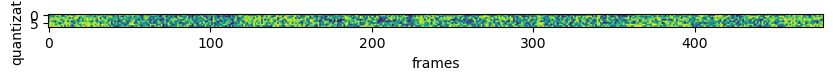

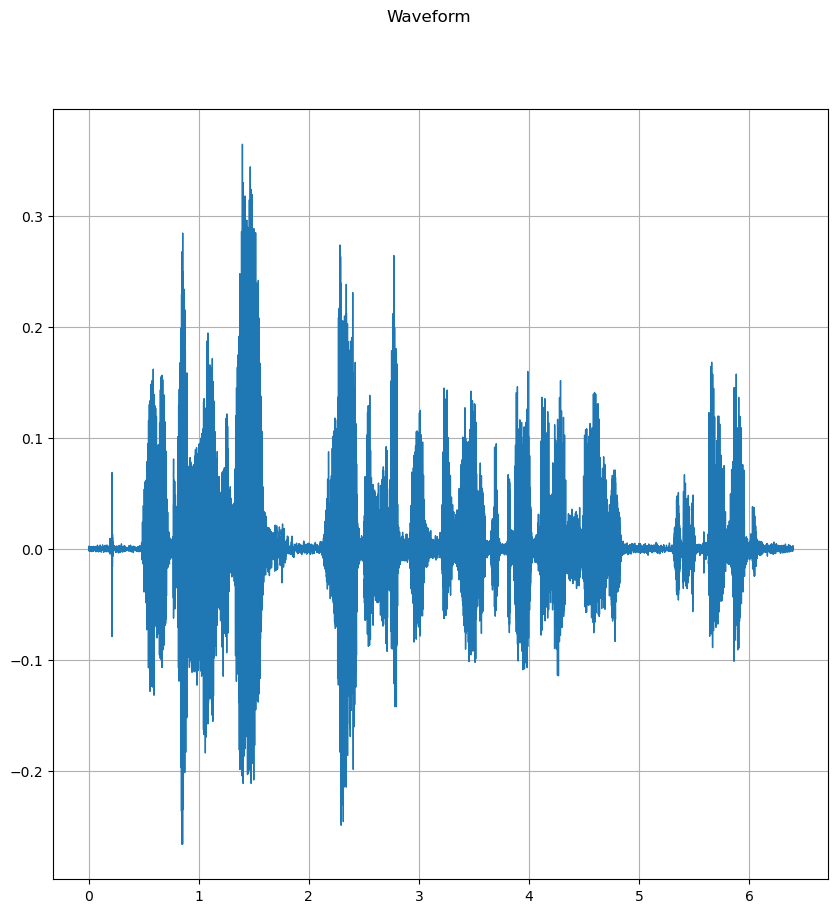

In [ ]:
wav, sr = torchaudio.load("../data/obama.wav")
encodec = EncoDec(device='cpu')
codes = encodec(wav,sr)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('frames')
plt.ylabel('quantization')
plt.imshow(codes.squeeze().cpu().numpy())
decoded = encodec.decode(codes)
plot_waveform(decoded.detach().cpu().squeeze(0), encodec.sample_rate)


In [ ]:
#| hide
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
print(model.sample_rate)

24000


In [ ]:
#| hide
# Load and pre-process the audio waveform
wav, sr = torchaudio.load("../data/obama.wav")
# mono & resampled
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

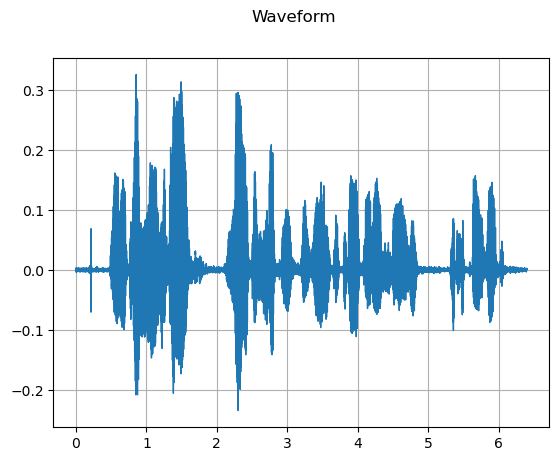

In [ ]:
#| hide
plot_waveform(wav.squeeze(0), model.sample_rate)

In [ ]:
#| hide
ipd.Audio(wav.squeeze(0).numpy(), rate=sr)

In [ ]:
#| hide
# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]


In [ ]:
#| hide
print(len(encoded_frames), len(encoded_frames[0]))
print(encoded_frames[0][0].shape)
print(codes.shape)

1 2
torch.Size([1, 8, 480])
torch.Size([1, 8, 480])


In [ ]:
#| hide
print(encoded_frames)

[(tensor([[[ 408,  106,  876,  ...,  876,  738, 1017],
         [ 937,  363,  544,  ...,  544,  544,  913],
         [  36,  915,  989,  ...,  989,  989,  821],
         ...,
         [ 903,  982,  939,  ...,  851,  683,  986],
         [ 900,  977,  748,  ...,  772,  834,  772],
         [ 975,  948,  828,  ...,  701,  975,  975]]]), None)]


In [ ]:
#| hide
print(codes)

tensor([[[ 408,  106,  876,  ...,  876,  738, 1017],
         [ 937,  363,  544,  ...,  544,  544,  913],
         [  36,  915,  989,  ...,  989,  989,  821],
         ...,
         [ 903,  982,  939,  ...,  851,  683,  986],
         [ 900,  977,  748,  ...,  772,  834,  772],
         [ 975,  948,  828,  ...,  701,  975,  975]]])


In [ ]:
#| hide
encoded_frames[0][0] == codes

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

<matplotlib.image.AxesImage>

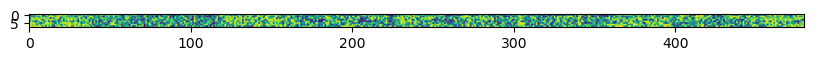

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(codes.squeeze().numpy())

In [ ]:
print(codes)
print(encoded_frames)

tensor([[[ 408,  106,  876,  ...,  876,  738, 1017],
         [ 937,  363,  544,  ...,  544,  544,  913],
         [  36,  915,  989,  ...,  989,  989,  821],
         ...,
         [ 903,  982,  939,  ...,  851,  683,  986],
         [ 900,  977,  748,  ...,  772,  834,  772],
         [ 975,  948,  828,  ...,  701,  975,  975]]])
[(tensor([[[ 408,  106,  876,  ...,  876,  738, 1017],
         [ 937,  363,  544,  ...,  544,  544,  913],
         [  36,  915,  989,  ...,  989,  989,  821],
         ...,
         [ 903,  982,  939,  ...,  851,  683,  986],
         [ 900,  977,  748,  ...,  772,  834,  772],
         [ 975,  948,  828,  ...,  701,  975,  975]]]), None)]


In [ ]:
frames_from_code = [(codes, None)]
print(frames_from_code)
decoded = model.decode(encoded_frames=frames_from_code)
# decoded.shape

[(tensor([[[ 408,  106,  876,  ...,  876,  738, 1017],
         [ 937,  363,  544,  ...,  544,  544,  913],
         [  36,  915,  989,  ...,  989,  989,  821],
         ...,
         [ 903,  982,  939,  ...,  851,  683,  986],
         [ 900,  977,  748,  ...,  772,  834,  772],
         [ 975,  948,  828,  ...,  701,  975,  975]]]), None)]


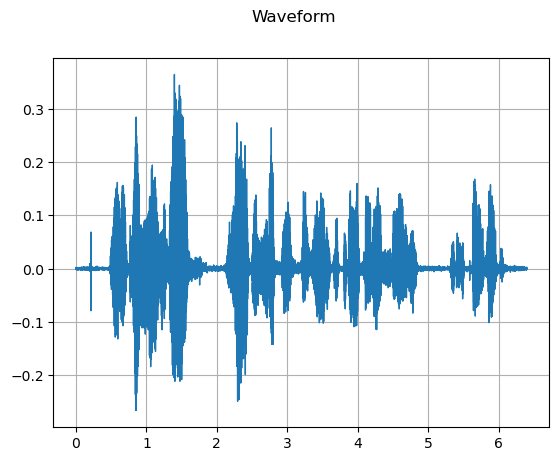

In [ ]:
plot_waveform(decoded.detach().squeeze(0), model.sample_rate)

In [ ]:
ipd.Audio(decoded.detach().squeeze(0).numpy(), rate=model.sample_rate)

## AudioLM

In [ ]:
# TO DO

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()